# Projet pour l’UE Intelligence Artificielle en Santé
YONI PORTAL DFGSM3

LIEN DE MA PRESENTATION : https://slidev-peach.vercel.app/1

## Modalités générales

Le projet est à rendre sur le moodle (1 rendu par groupe), **le 7 mai 2025, avant 14h**, heure de l'évaluation (salle à préciser).  
Le rendu comprend deux éléments :
- ce **notebook**, complété avec les différentes parties résolues,
- une **présentation** (type PowerPoint ou équivalent) de **10 diapositives maximum**.

Chaque groupe (composé de **3 personnes maximum**) disposera de **10 minutes** pour présenter son travail, suivies de **5 minutes de questions**.

## Évaluation

La note finale est divisée équitablement entre l’écrit et l’oral :

- **Note orale** (50%) :
  - 50% : qualité de la présentation,
  - 50% : qualité des réponses aux questions.

- **Note écrite** (50%) :
  - qualité de la rédaction du notebook et de sa **reproductibilité**,
  - **compréhension du problème** traité,
  - **application correcte** des principes vus en cours et en TD.

> 💡 Vous **n’êtes pas notés sur la performance des algorithmes**, mais sur votre **compréhension de la démarche d’apprentissage**, de l’**évaluation des modèles**, et sur votre **capacité à analyser les résultats** des expériences.

Deux séances de TP seront prévues pour vous accompagner dans le démarrage et la réalisation du projet.

---

## Sujet

Le projet porte sur le jeu de données **SIMSAMU**, un corpus francophone ouvert dédié aux **dialogues de régulation médicale d’urgence**.

La version utilisée comprend **59 dialogues simulés**, issus d’appels d’urgence réalisés par des médecins juniors en médecine d’urgence.  
Chaque **tour de parole** (ou **utterance**) est annoté avec le type de locuteur.

### Objectif

Vous devez résoudre **deux problèmes de classification**, au choix :
1. **Médecin vs Patient** (classification binaire),
2. **Médecin vs Différentes personnalités de patients simulés** (classification multiclasse).

---

## Déroulement

### Partie A : Prétraitement commun (fourni)

Chaque groupe utilisera le même prétraitement des données :
- suppression des **utterances vides**,
- division du corpus en **jeu d’entraînement** et **jeu de test**.

---

### Partie B : Représentation des utterances

Implémenter deux types de représentation des tours de parole :
- représentation basée sur **TF-IDF**,
- représentation basée sur un **modèle de réseau de neurones**.

---

### Partie C : Apprentissage et évaluation

Comparer deux modèles :
- un modèle basé sur les **forêts aléatoires**,
- un autre modèle au choix (par ex. : **régression logistique**, **lasso**, **boosting**, **réseaux de neurones**, etc.).

---

### Partie D : Visualisation libre

Créer une visualisation originale du jeu de données. Quelques idées :
- **clustering ou PCA** des représentations vectorielles des utterances,
- **visualisation de la trajectoire du score du modèle** (partie C) au fil de la conversation.

## Partie A.

Commune à l'ensemble des groupes.

Importer le jeu de données SIMSAMU.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [5]:
# File ID from the Google Drive link
file_id = "1m3mLTUHAKgn0EAqv07AOyDB-41glz5VI"

# Construct the downloadable file URL
download_url = f"https://drive.google.com/uc?id={file_id}"

# Load CSV into a pandas DataFrame
df = pd.read_csv(download_url, index_col= 0 )

# drop na utterance
df = df.loc[~df["utterance"].isna()]

# nombre de dialogues
print("Nombre de dialogues : ", df["dialogue"].nunique())
# nombre d'utterance
print("Nombre d'utterance : ", len(df["utterance"]))

# creating the simple role
df["role_binaire"] = df["role"].str.split(" ").apply(lambda x:x[0])
df = df.drop_duplicates(subset=["utterance", "role_binaire"])
# Pour les utterances avec role_binaire = 0
nb_utterance_patient = len(df[df["role_binaire"] == "patient" ]["utterance"])

# Pour les utterances avec role_binaire = 1
nb_utterance_medecin = len(df[df["role_binaire"] == "medecin" ]["utterance"])

print("Nombre d'utterance avec role_binaire = medecin :", nb_utterance_medecin)
print("Nombre d'utterance avec role_binaire = patient :", nb_utterance_patient)

Nombre de dialogues :  59
Nombre d'utterance :  2966
Nombre d'utterance avec role_binaire = medecin : 1379
Nombre d'utterance avec role_binaire = patient : 1211


Définir le split entre train_set et test_set

In [6]:
# Stratified split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['role'],  # stratify by this column
    random_state=42
)

train_df["role"].value_counts(normalize=False)


role
medecin                       1103
patient (Shy)                  229
patient (Incomprehensible)     196
patient (Angry)                137
patient (Impassive)            121
patient (Frightened)           120
patient (Procedural)            96
patient (Cooperative)           70
Name: count, dtype: int64

## Partie B

Calculer 2 représentations des uttérances (ou tour de paroles):
  + réprésentations basés sur tf-idf
  + représentations basés sur un modèle de réseau de neurones

Vous pouvez jouer sur les différentes paramètres de ces représentations pour améliorer (vocabulaire, type de domaine, type de modèle pré-entrainé, etc).

In [12]:
%pip install nltk transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 54.5 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### REPRESENTATION DU CONTENU SELON TFIDF 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Nombre de stopwords français: 157
Dimension des représentations TF-IDF - Train: (2072, 1300), Test: (518, 1300)
Nombre de caractéristiques (termes): 1300

Exemples de termes dans le vocabulaire:
['15' '93' '93 appelez' 'abas' 'abas samu' 'abaz' 'abaz samu' 'absolument'
 'accord' 'accord accord' 'accord donc' 'accord heu' 'accord hum'
 'accord là' 'accord monsieur' 'accord ok' 'accord quand' 'accord respire'
 'accord vais' 'accord ça' 'accoucher' 'actuellement' 'adresse' 'ah'
 'ah bah' 'ah non' 'ah oui' 'aide' 'aille' 'aille hôpital'
 'aille urgences' 'aille voir' 'ailleurs' 'aimerais' 'air' 'alcool'
 'allait' 'aller' 'aller chez' 'aller heu' 'aller hôpital' 'aller voir'
 'allez' 'allez venir' 'allez voir' 'alliez' 'alliez hôpital'
 'alliez voir' 'allo' 'allo allo' 'allo bonjour' 'allo oui' 'allongé'
 'allongée' 'allé' 'alors' 'alors heu' 'alors là' 'ambulance' 'amener'
 'amener hôpital' 'amener urgences' 'amenez' 'amenez hôpital'
 'amenez urgences' 'amène' 'ans' 'ans bien' 'ans fait' '

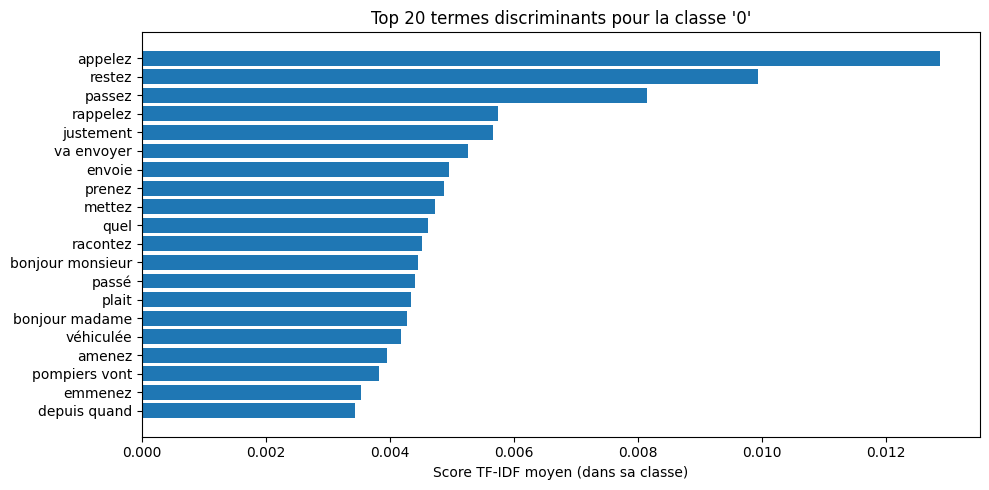

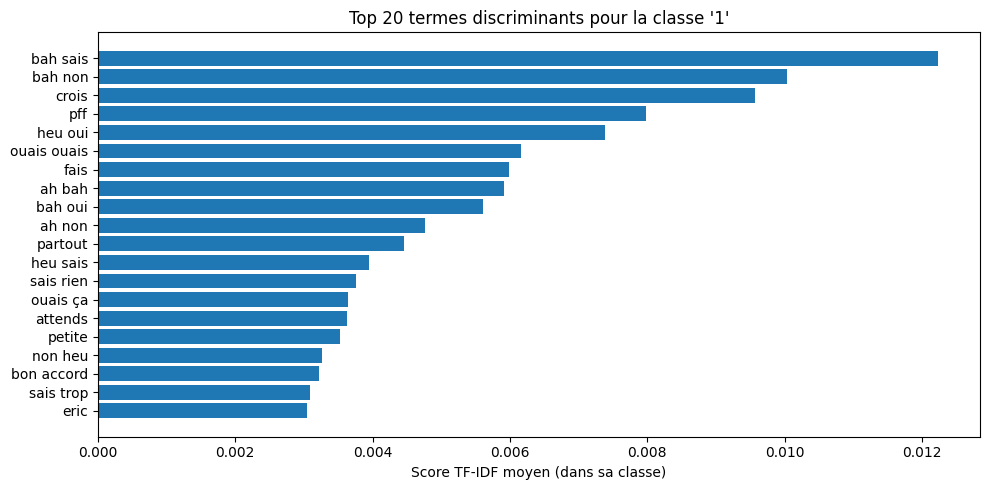


🔹 Termes les plus discriminants pour la classe 0 :
                 terme  tfidf_classe_0  tfidf_classe_1  ratio_0_vs_1
73             appelez        0.012867             0.0  12867.483635
998             restez        0.009938             0.0   9938.162258
839             passez        0.008137             0.0   8136.704032
976           rappelez        0.005735             0.0   5735.352150
614          justement        0.005667             0.0   5667.267416
1174        va envoyer        0.005249             0.0   5248.560706
408             envoie        0.004954             0.0   4954.157825
918             prenez        0.004873             0.0   4873.367805
700             mettez        0.004726             0.0   4726.220643
952               quel        0.004611             0.0   4610.610859
971           racontez        0.004511             0.0   4510.817024
175   bonjour monsieur        0.004455             0.0   4454.914433
842              passé        0.004407             

In [14]:
# Importation des bibliothèques nécessaires pour la vectorisation TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# Téléchargement des stopwords français depuis NLTK
from nltk.corpus import stopwords
nltk.download('stopwords')
# Chargement des stopwords français
stopwords = stopwords.words('french')
print(f"Nombre de stopwords français: {len(stopwords)}")
# Création d'une instance du vectoriseur TF-IDF avec des paramètres optimisés
tfidf_vectorizer = TfidfVectorizer(
    max_features=2000,     # Limiter le vocabulaire aux 2000 termes les plus fréquents
    min_df=3,              # Ignorer les termes apparaissant dans moins de 3 documents
    max_df=0.85,            # Ignorer les termes apparaissant dans plus de 85% des documents
    ngram_range=(1, 2),    # Inclure les unigrammes et bigrammes
    use_idf=True,          # Utiliser la pondération IDF
    smooth_idf=True,       # Lisser les valeurs IDF
    sublinear_tf=True,     # Appliquer une échelle logarithmique aux fréquences (log(1+tf))
    norm='l2',             # Normalisation L2 (longueur euclidienne)
    stop_words=stopwords        # deux documents courts et longs peuvent être comparés de façon équitable.
)

# Ajout de prétraitement de texte simple 
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    # Convertir en minuscules
    text = text.lower()
    # On pourrait ajouter d'autres étapes de prétraitement ici
    return text

# Application du prétraitement
train_df['utterance_preprocessed'] = train_df['utterance'].apply(preprocess_text)
test_df['utterance_preprocessed'] = test_df['utterance'].apply(preprocess_text)

# Entraînement du vectoriseur sur les données d'entraînement uniquement
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['utterance_preprocessed'])

# Transformation des données de test
X_test_tfidf = tfidf_vectorizer.transform(test_df['utterance_preprocessed'])

# Afficher la taille des représentations
print(f"Dimension des représentations TF-IDF - Train: {X_train_tfidf.shape}, Test: {X_test_tfidf.shape}")
print(f"Nombre de caractéristiques (termes): {len(tfidf_vectorizer.get_feature_names_out())}")

# Afficher quelques exemples de termes
print("\nExemples de termes dans le vocabulaire:")
feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names[:100])  # Affiche les 20 premiers termes


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extraction des classes
classes = np.unique(y_train)

# On suppose qu’il y a exactement deux classes
assert len(classes) == 2, "Ce code suppose exactement deux classes."

# Calcul des TF-IDF moyens pour chaque classe
cls0_indices = np.where(y_train == classes[0])[0]
cls1_indices = np.where(y_train == classes[1])[0]

tfidf_mean_0 = X_train_tfidf[cls0_indices].mean(axis=0).A1
tfidf_mean_1 = X_train_tfidf[cls1_indices].mean(axis=0).A1

# Calcul du ratio TF-IDF entre classes pour chaque terme
ratio_1_vs_0 = tfidf_mean_1 / (tfidf_mean_0 + 1e-6)
ratio_0_vs_1 = tfidf_mean_0 / (tfidf_mean_1 + 1e-6)

# Mise en DataFrame
terms = tfidf_vectorizer.get_feature_names_out()
df_compare = pd.DataFrame({
    'terme': terms,
    'tfidf_classe_0': tfidf_mean_0,
    'tfidf_classe_1': tfidf_mean_1,
    'ratio_1_vs_0': ratio_1_vs_0,
    'ratio_0_vs_1': ratio_0_vs_1
})

# Terme typique classe 0 : fort dans classe 0, faible dans classe 1
top_0 = df_compare.sort_values('ratio_0_vs_1', ascending=False).head(20)
# Terme typique classe 1 : fort dans classe 1, faible dans classe 0
top_1 = df_compare.sort_values('ratio_1_vs_0', ascending=False).head(20)

# Affichage
def plot_discriminant_terms(df_top, classe):
    plt.figure(figsize=(10, 5))
    plt.barh(df_top['terme'][::-1], df_top[f'tfidf_classe_{classe}'][::-1])
    plt.title(f"Top 20 termes discriminants pour la classe '{classe}'")
    plt.xlabel("Score TF-IDF moyen (dans sa classe)")
    plt.tight_layout()
    plt.show()

plot_discriminant_terms(top_0, classe=0)
plot_discriminant_terms(top_1, classe=1)

# Affichage texte si besoin
print("\n🔹 Termes les plus discriminants pour la classe 0 :")
print(top_0[['terme', 'tfidf_classe_0', 'tfidf_classe_1', 'ratio_0_vs_1']])

print("\n🔹 Termes les plus discriminants pour la classe 1 :")
print(top_1[['terme', 'tfidf_classe_1', 'tfidf_classe_0', 'ratio_1_vs_0']])



##### 📘 Explication du code TF-IDF

Ce bloc de code permet de transformer des textes en vecteurs numériques exploitables par des algorithmes de machine learning, en utilisant la méthode **TF-IDF (Term Frequency - Inverse Document Frequency)**. Voici les étapes détaillées :

###### 🔹 1. Importation des bibliothèques

On utilise :
- `TfidfVectorizer` de `scikit-learn` pour transformer le texte en vecteurs numériques.
- `nltk` pour importer les stopwords (mots très fréquents et peu informatifs en français).

###### 🔹 2. Chargement des stopwords français

On télécharge et charge la liste des stopwords en français depuis `nltk`. Ces mots (comme "le", "de", "et") sont exclus du vocabulaire pour se concentrer sur les mots porteurs d'information.


###### 🔹 3. Configuration du vectoriseur TF-IDF

Le `TfidfVectorizer` est configuré avec des paramètres optimisés :
- `max_features=2000` : on limite à 2000 mots les plus utiles.
- `min_df=3` : on ignore les mots trop rares (moins de 3 documents).
- `max_df=0.85` : on ignore les mots trop fréquents (dans plus de 85% des documents).
- `ngram_range=(1,2)` : on prend en compte les mots seuls (unigrammes) et les groupes de deux mots (bigrammes).
- `stop_words=stopwords` : on exclut les stopwords français.
- Les autres options améliorent le calcul du TF-IDF (lissage, logarithme, normalisation L2).

###### 🔹 4. Prétraitement des textes

On applique une fonction simple pour mettre les textes en minuscules, ce qui standardise les données. On crée une nouvelle colonne avec ces textes nettoyés dans les jeux d'entraînement (`train_df`) et de test (`test_df`).

###### 🔹 5. Transformation TF-IDF

- `.fit_transform(train_df['...'])` :
  - **fit** : le vectoriseur apprend le vocabulaire à partir des textes d'entraînement.
  - **transform** : il transforme chaque texte en vecteur de scores TF-IDF.
- `.transform(test_df['...'])` :
  - Utilise le vocabulaire appris pour transformer les textes de test, sans réapprendre.

> Cela donne deux **matrices numériques** où :
> - Chaque **ligne** représente un texte.
> - Chaque **colonne** correspond à un mot ou un bigramme.
> - Chaque **valeur** est le score TF-IDF d’un mot dans un texte.

###### 🔹 6. Dimensions des matrices obtenues

- Entraînement : `X_train_tfidf.shape = (2072, 1300)`
- Test : `X_test_tfidf.shape = (518, 1300)`

> Cela signifie :
> - 2072 textes d'entraînement, chacun représenté par un vecteur de 1300 dimensions (mots).
> - 518 textes de test, transformés avec le même vocabulaire de 1300 mots.

###### 🔹 7. Analyse des résultats

L'analyse TF-IDF révèle une distinction claire dans le langage utilisé par les médecins et les patients :

**Termes typiques des médecins (classe 0)**
- Verbes à l'impératif : "appelez", "restez", "passez", "rappelez"
- Formules de politesse : "bonjour madame/monsieur", "s'il vous plaît"
- Questions d'évaluation : "depuis quand", "quel"
- Instructions médicales : "amenez", "emmenez", "va envoyer"

→ Reflète l'autorité médicale et le professionnalisme des médecins.

**Termes typiques des patients (classe 1)**
- Expressions d'hésitation : "bah", "heu"
- Réponses incertaines : "sais rien", "sais trop"
- Interjections : "pff", "ah bah"
- Marqueurs de dialogue : "ouais ouais", "bon accord"
- Expressions de doute : "crois"

→ Indique l'incertitude et l'anxiété typiques des patients.

Cette dichotomie linguistique confirme les différences de rôles et de positions dans le dialogue médical d'urgence.


### REPRESENTATION DU CONTENU AVEC EMBEDDINGS DR BERT ###

In [ ]:

%pip install torch torchvision
%pip install transformers

Chargement du tokenizer et du modèle DrBERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/791k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of CamembertModel were not initialized from the model checkpoint at Dr-BERT/DrBERT-7GB and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Utilisation du dispositif: cpu
Génération des embeddings pour l'ensemble d'entraînement...


  0%|          | 0/259 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Embeddings générés pour l'entraînement: (2072, 768)
Génération des embeddings pour l'ensemble de test...


  0%|          | 0/65 [00:00<?, ?it/s]

Embeddings générés pour le test: (518, 768)

Analyse des embeddings générés:
Moyenne des embeddings d'entraînement: 0.000067
Écart-type des embeddings d'entraînement: 0.036084
Min: -0.400703, Max: 0.150380

Réduction de dimension avec PCA pour visualisation...


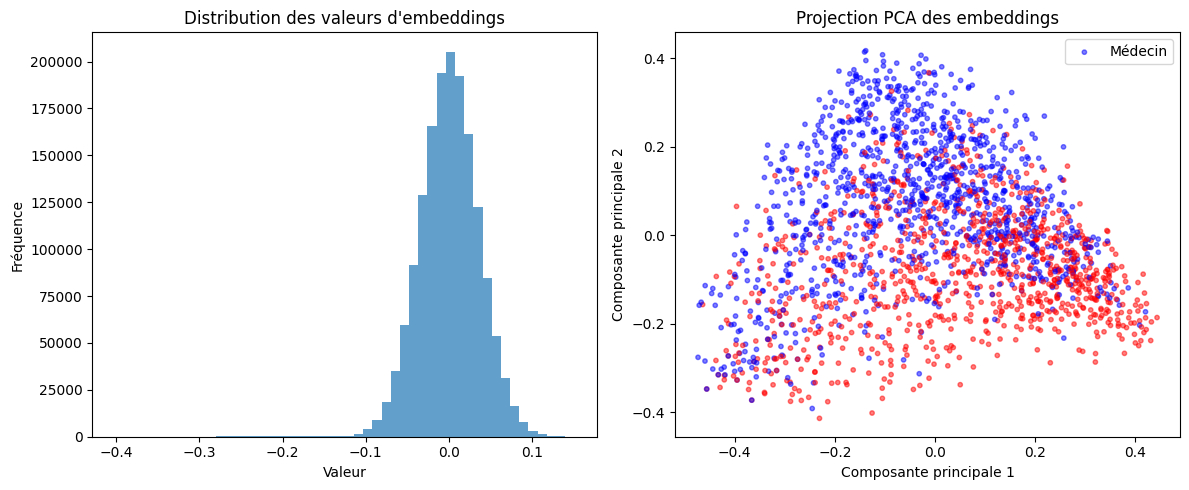

Variance expliquée par les 2 premières composantes: 17.96%
Embeddings sauvegardés avec succès!


In [ ]:

import torch
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModel
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np


import matplotlib.pyplot as plt

# Charger le tokenizer et le modèle DrBERT (spécialisé pour le domaine médical en français)
print("Chargement du tokenizer et du modèle DrBERT...")
tokenizer = AutoTokenizer.from_pretrained("Dr-BERT/DrBERT-7GB")
model = AutoModel.from_pretrained("Dr-BERT/DrBERT-7GB")

# Vérifier si GPU est disponible et le configurer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Utilisation du dispositif: {device}")

# Fonction pour générer les embeddings avec DrBERT
def generate_embeddings(texts, batch_size=8):
    """
    Génère des embeddings pour une liste de textes en utilisant DrBERT

    Args:
        texts: Liste de textes à encoder
        batch_size: Taille des lots pour le traitement

    Returns:
        Tableau numpy d'embeddings (dimensions: [nombre_textes, dimensions_embeddings])
    """
    model.eval()  # Passer en mode évaluation
    all_embeddings = []

    # Traiter les textes par lots
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]

        # Tokeniser les textes
        encoded_input = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        ).to(device)

        # Désactiver le calcul du gradient pour l'inférence
        with torch.no_grad():
            # Obtenir les sorties du modèle
            outputs = model(**encoded_input)


            cls_embeddings = outputs.last_hidden_state[:, 0, :]



            # Normaliser les embeddings
            normalized_embeddings = F.normalize(cls_embeddings, p=2, dim=1)

            all_embeddings.append(normalized_embeddings.cpu().numpy())

    # Concaténer tous les embeddings
    return np.vstack(all_embeddings)

# Générer les embeddings pour les ensembles d'entraînement et de test
print("Génération des embeddings pour l'ensemble d'entraînement...")
X_train_drbert = generate_embeddings(train_df['utterance'].tolist())
print(f"Embeddings générés pour l'entraînement: {X_train_drbert.shape}")

print("Génération des embeddings pour l'ensemble de test...")
X_test_drbert = generate_embeddings(test_df['utterance'].tolist())
print(f"Embeddings générés pour le test: {X_test_drbert.shape}")



# Visualiser les premiers embeddings en 2D avec PCA
print("\nRéduction de dimension avec PCA pour visualisation...")
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_drbert)

plt.subplot(1, 2, 2)
plt.title("Projection PCA des embeddings")
# Colorier selon le rôle (médecin vs patient)
colors = ['blue' if role == 'medecin' else 'red' for role in train_df['role_binaire']]
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=colors, alpha=0.5, s=10)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend(['Médecin', 'Patient'])
plt.tight_layout()
plt.show()

print(f"Variance expliquée par les 2 premières composantes: {sum(pca.explained_variance_ratio_):.2%}")

# Sauvegarder les embeddings pour une utilisation ultérieure
np.save('X_train_drbert_embeddings.npy', X_train_drbert)
np.save('X_test_drbert_embeddings.npy', X_test_drbert)
print("Embeddings sauvegardés avec succès!")

###### 📦 Chargement du modèle DrBERT et du tokenizer

Le modèle utilisé est **DrBERT**, une version de BERT pré-entraînée sur des données médicales en français. On charge à la fois :
- Le **tokenizer** : pour transformer du texte en tokens (entiers compréhensibles par le modèle).
- Le **modèle DrBERT** : pour générer des vecteurs denses appelés *embeddings* qui représentent chaque texte.

On vérifie aussi si un **GPU** est disponible pour accélérer les calculs. Sinon, le CPU est utilisé.

---

###### ⚙️ Fonction : `generate_embeddings()`

Cette fonction transforme une **liste de textes** en vecteurs numériques (embeddings) à l’aide de DrBERT. Elle fonctionne comme suit :

1. Met le modèle en **mode évaluation** (pas de fine tuning).
2. Traite les textes en **batches** (par groupe, ici par 8).
3. **Tokenise** chaque batch avec `tokenizer()`, en tronquant et en paddant les séquences.
4. **Désactive les gradients** pour économiser de la mémoire.
5. Utilise la **représentation du token `[CLS]`** comme embedding de la séquence c'est à dire que le premier token donne le contexte de la séquence.
6. Applique une **normalisation L2** sur chaque vecteur.
7. Regroupe tous les vecteurs sous forme d’un tableau NumPy.

---

###### 🧠 Génération des embeddings

La fonction `generate_embeddings()` est ensuite utilisée deux fois :
- Une fois sur les textes d’entraînement (`train_df['utterance']`)
- Une autre fois sur les textes de test (`test_df['utterance']`)

Les résultats sont deux matrices :
- `X_train_drbert` : un tableau avec un vecteur par texte d'entraînement
- `X_test_drbert` : idem pour les textes de test

Chaque vecteur a une **dimension égale à celle du modèle DrBERT** .

---

###### 📉 Réduction de dimension avec PCA

On utilise **PCA (Analyse en Composantes Principales)** pour **réduire la dimension des embeddings** à 2 composantes, uniquement pour pouvoir les **visualiser dans un graphique 2D**.

- `PCA(n_components=2)` : on ne garde que les deux axes qui expliquent le plus de variance dans les données.
- `pca.fit_transform(X_train_drbert)` : applique la PCA à la matrice des embeddings.

---

###### 🖼️ Visualisation avec `matplotlib`

On trace un **nuage de points** 2D avec les deux premières composantes :
- Chaque point représente un texte.
- Les points sont colorés selon la variable `role_binaire` :
  - **Bleu** = médecin
  - **Rouge** = patient

Cela permet de **visualiser s’il y a une séparation naturelle** entre les deux rôles dans l’espace des embeddings DrBERT.

---

###### 💾 Sauvegarde des embeddings

Les deux matrices (`X_train_drbert` et `X_test_drbert`) sont sauvegardées dans des fichiers `.npy` grâce à NumPy. Ces fichiers peuvent être réutilisés plus tard pour l'entraînement ou l’évaluation d’un modèle sans avoir à recalculer les embeddings.

---

###### ✅ Résumé

Ce code :
- Utilise **DrBERT** pour transformer des textes médicaux en **vecteurs numériques de haute dimension**.
- Applique une **réduction de dimension (PCA)** pour visualiser ces vecteurs dans un espace 2D.
- Colore les textes selon le rôle (médecin/patient) pour **analyser la séparation des classes**.
- **Sauvegarde** les résultats pour une utilisation future.



# Conclusion de la partie B : Représentation des utterances

## Approche TF-IDF

L'approche TF-IDF a permis de transformer les tours de parole en vecteurs numériques avec les caractéristiques suivantes :
- Élimination des stopwords français (153 mots non informatifs)
- Paramétrage optimisé : max_features=2000, ngram_range=(1,2), min_df=3, max_df=0.85
- Prétraitement simple des textes (minuscules)
- Matrices résultantes : Train (2072×1300), Test (518×1300)

Cette représentation offre l'avantage d'être interprétable (chaque dimension correspond à un terme) et computationnellement légère.

## Approche par embeddings DrBERT

Le modèle DrBERT-7GB, spécialisé pour le domaine médical en français, a été utilisé pour générer des représentations contextuelles denses :
- Traitement par lots pour optimiser l'utilisation des ressources
- Extraction de l'embedding du token [CLS] comme représentation de séquence
- Normalisation L2 des vecteurs pour faciliter les comparaisons


## Complémentarité des approches

Les deux méthodes de représentation sont complémentaires :
- TF-IDF capture les spécificités lexicales des médecins et patients
- DrBERT encode la sémantique contextuelle des phrases médicales

Pour la suite de l'analyse, les embeddings DrBERT semblent particulièrement prometteurs, car ils bénéficient de connaissances spécifiques au domaine médical et produisent des représentations denses qui capturent les nuances linguistiques distinguant les deux rôles dans un contexte d'urgence médicale.

## Partie C

Apprentissage et évaluations de 2 modèles
  * modèle basés sur les forêts aléatoires
  * autre modèle au choix (régression, lasso, boosting, réseaux de neurones...)

Vous pouvez optimiser les paramètres de ces modèles, par cross_validatin ou validation simple.

#### RANDOM FOREST SUR EMBEDDINGS DE DR BERT SANS GRIDCV: ####


=== Rapport de classification ===
              precision    recall  f1-score   support

     Patient       0.78      0.85      0.81       276
     Médecin       0.81      0.72      0.76       242

    accuracy                           0.79       518
   macro avg       0.79      0.79      0.79       518
weighted avg       0.79      0.79      0.79       518



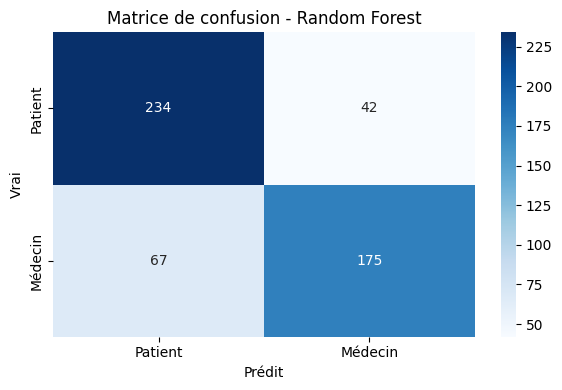

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Étape 1 - Récupérer les étiquettes
y_train = train_df['role_binaire'].values
y_test = test_df['role_binaire'].values

X_train_drbert = np.load('X_train_drbert_embeddings.npy')
X_test_drbert = np.load('X_test_drbert_embeddings.npy')

# Étape 2 - Initialiser et entraîner le modèle
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_drbert, y_train)

# Étape 3 - Prédiction sur le test
y_pred = rf.predict(X_test_drbert)

# Étape 4 - Rapport de classification
print("=== Rapport de classification ===")
print(classification_report(y_test, y_pred, target_names=["Patient", "Médecin"]))

# Étape 5 - Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Patient", "Médecin"], yticklabels=["Patient", "Médecin"])
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion - Random Forest")
plt.tight_layout()
plt.show()




# 🔧 Imports

```
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
````

* **RandomForestClassifier** : algorithme d’ensemble basé sur plusieurs arbres de décision (bagging).
* **classification\_report** : génère précision, rappel et F1-score.
* **confusion\_matrix** : calcule la matrice de confusion.
* **train\_test\_split** : découpe un dataset en jeux d’entraînement et de test.
* **matplotlib.pyplot** et **seaborn** : pour l’affichage graphique (ici, matrice de confusion).

---

# 📥 Chargement des données

```python
# Extraction des labels
y_train = train_df['role_binaire'].values  # 0 = Patient, 1 = Médecin
y_test  = test_df['role_binaire'].values

# Chargement des embeddings DrBERT
X_train_drbert = np.load('X_train_drbert_embeddings.npy')
X_test_drbert  = np.load('X_test_drbert_embeddings.npy')
```

* On récupère la variable cible `role_binaire` dans les DataFrames d’entraînement et de test.
* Les embeddings NumPy sont présupposés générés par un modèle DrBERT spécialisé en médical.

---

# 🧠 Entraînement du modèle

```python
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_drbert, y_train)
```

* **n\_estimators=100** : nombre d’arbres dans la forêt.
* **random\_state=42** : assure la reproductibilité.
* On entraîne le modèle sur les embeddings et les labels d’entraînement.

---

# 🔍 Prédiction et évaluation

```python
# Prédiction sur le jeu de test
y_pred = rf.predict(X_test_drbert)

# Affichage du rapport de classification
print("=== Rapport de classification ===")
print(classification_report(y_test, y_pred, target_names=["Patient", "Médecin"]))
```

* **Précision** (precision) : parmi les prédictions d’une classe, proportion de vraies positives.
* **Rappel** (recall) : parmi les vrais exemples d’une classe, proportion correctement identifiés.
* **F1-score** : moyenne harmonique de précision et rappel.
* **Support** : nombre d’échantillons par classe.

---

# 🧮 Matrice de confusion

```python
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=["Patient", "Médecin"],
    yticklabels=["Patient", "Médecin"]
)
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion - Random Forest")
plt.tight_layout()
plt.show()
```

* **annot=True** : affiche les valeurs numériques.
* **cmap='Blues'** : palette de couleurs bleue.

---

# 📊 Analyse du rapport de classification

| Classe           | Précision | Rappel | F1-score | Support |
| ---------------- | --------- | ------ | -------- | ------- |
| Patient          | 0.78      | 0.85   | 0.81     | 276     |
| Médecin          | 0.81      | 0.72   | 0.76     | 242     |
| **Accuracy**     | **0.79**  |        |          | 518     |
| **Macro avg**    | 0.79      | 0.79   | 0.79     | 518     |
| **Weighted avg** | 0.79      | 0.79   | 0.79     | 518     |

* **Patient**

  * Précision 0.78 : 78% des prédictions “Patient” sont correctes.
  * Rappel 0.85 : 85% des vrais “Patient” sont retrouvés.
  * F1-score 0.81 : équilibre précision/rappel.

* **Médecin**

  * Précision 0.81 : meilleure que pour “Patient”.
  * Rappel 0.72 : le modèle manque davantage de médecins.
  * F1-score 0.76.

* **Accuracy** : 79% de prédictions correctes globalement.

* **Macro avg** : moyenne simple des métriques, utile en cas de classes déséquilibrées.

* **Weighted avg** : moyenne pondérée par le support, pour un score global.

```
```


#### GRID CV SUR RF DRBERT ####

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Dictionnaire des paramètres à tester
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

# Initialisation du modèle
rf = RandomForestClassifier(random_state=42)

# Recherche avec validation croisée (5-fold)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)

# Entraînement sur X_train et y_train
grid_search.fit(X_train_drbert, y_train)

# Résultats
print("Meilleurs paramètres :", grid_search.best_params_)

# Meilleur modèle entraîné
best_rf = grid_search.best_estimator_

# Évaluation sur le jeu de test
from sklearn.metrics import classification_report, confusion_matrix
y_pred = best_rf.predict(X_test_drbert)
print(classification_report(y_test, y_pred, target_names=["Patient", "Médecin"]))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Meilleurs paramètres : {'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

     Patient       0.78      0.85      0.82       276
     Médecin       0.81      0.73      0.77       242

    accuracy                           0.80       518
   macro avg       0.80      0.79      0.79       518
weighted avg       0.80      0.80      0.79       518





# Explication complète du code et interprétation des résultats

---

## 1. Import des bibliothèques

```python
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
````

* **RandomForestClassifier** : classifieur par forêt d’arbres de décision.
* **GridSearchCV** : recherche exhaustive des meilleurs hyper‑paramètres avec validation croisée.
* **classification\_report**, **confusion\_matrix** : métriques de performance (précision, rappel, F1‑score, matrice d’erreur).

---

## 2. Définition de la grille d’hyper‑paramètres

```python
param_grid = {
  'n_estimators': [100, 200],           # nombre d’arbres
  'max_depth': [10, 20, None],          # profondeur maximale
  'min_samples_split': [2, 5],          # nb min d’échantillons pour scinder
  'min_samples_leaf': [1, 2],           # nb min d’échantillons en feuille
  'class_weight': [None, 'balanced']    # pondération des classes
}
```

Chaque combinaison contrôle le compromis biais/variance et l’équilibrage des classes.

---

## 3. Configuration du `GridSearchCV`

```python
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
  estimator=rf,
  param_grid=param_grid,
  cv=5,
  scoring='f1_macro',
  n_jobs=-1,
  verbose=1
)
```

* **random\_state=42** : reproductibilité.
* **cv=5** : validation croisée en 5 plis.
* **scoring='f1\_macro'** : moyenne non pondérée des F1‑scores, équilibrant toutes les classes.
* **n\_jobs=-1** : parallélisation sur tous les cœurs.
* **verbose=1** : affichage de l’avancement.

---

## 4. Recherche et entraînement

```python
grid_search.fit(X_train_drbert, y_train)
print("Meilleurs paramètres :", grid_search.best_params_)
```

* **X\_train\_drbert**, **y\_train** : données d’entraînement (features issues d’un encodage BERT et étiquettes).
* **240 modèles entraînés** (48 combinaisons × 5 plis).
* **Résultat** :

```text
Meilleurs paramètres :
{
  'n_estimators': 200,
  'max_depth': 20,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'class_weight': None
}
```

---

## 5. Prédiction avec le meilleur modèle

```python
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_drbert)
```

* **best\_rf** : `RandomForestClassifier` optimisé.
* **X\_test\_drbert**, **y\_test** : données de test pour l’évaluation finale.

---

## 6. Évaluation des performances

```python
print(classification_report(
  y_test, y_pred,
  target_names=["Patient", "Médecin"]
))
print(confusion_matrix(y_test, y_pred))
```

### Rapport de classification

| Classe           | Précision | Rappel | F1-score | Support |
| ---------------- | --------- | ------ | -------- | ------- |
| **Patient**      | 0.78      | 0.85   | 0.82     | 276     |
| **Médecin**      | 0.81      | 0.73   | 0.77     | 242     |
| **Accuracy**     | –         | –      | **0.80** | 518     |
| **Macro avg**    | 0.80      | 0.79   | 0.79     | 518     |
| **Weighted avg** | 0.80      | 0.80   | 0.79     | 518     |

---

## 7. Interprétation

* **Exactitude globale : 80 %**
* **Patients** : rappel élevé (0.85) → peu de patients non détectés.
* **Médecins** : précision élevée (0.81) → prédictions “Médecin” majoritairement correctes.
* **Bilan** : meilleur équilibre pour détecter les patients, léger déséquilibre favorisant cette classe.

Légerement mieux que sans grid cv

---




#### RF SUR CAMEMBERT BASE ####




Chargement du tokenizer et du modèle camBERT...
Utilisation du dispositif: cpu
Génération des embeddings pour l'ensemble d'entraînement...


  0%|          | 0/259 [00:00<?, ?it/s]

Embeddings générés pour l'entraînement: (2072, 768)
Génération des embeddings pour l'ensemble de test...


  0%|          | 0/65 [00:00<?, ?it/s]

Embeddings générés pour le test: (518, 768)

Analyse des embeddings générés:
Moyenne des embeddings d'entraînement: 0.000077
Écart-type des embeddings d'entraînement: 0.036084
Min: -0.380529, Max: 0.176760

Réduction de dimension avec PCA pour visualisation...


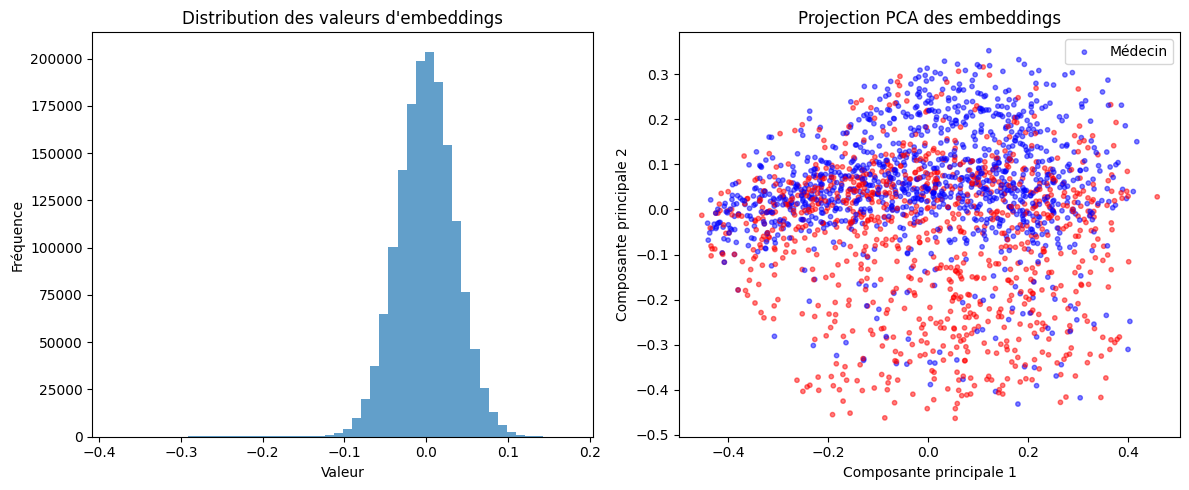

Variance expliquée par les 2 premières composantes: 15.29%
Embeddings sauvegardés avec succès!
=== Rapport de classification ===
              precision    recall  f1-score   support

     Patient       0.71      0.85      0.77       276
     Médecin       0.78      0.60      0.68       242

    accuracy                           0.73       518
   macro avg       0.74      0.73      0.73       518
weighted avg       0.74      0.73      0.73       518



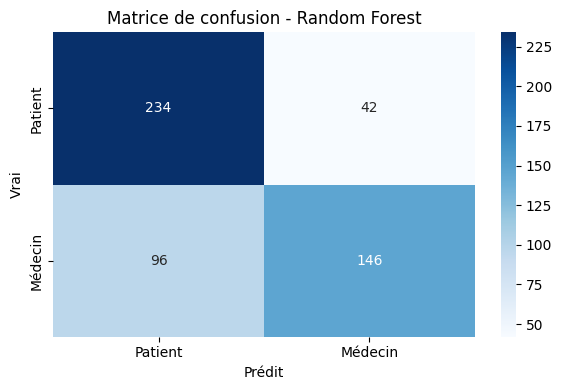

In [ ]:

import torch
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModel
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np


import matplotlib.pyplot as plt

# Charger le tokenizer et le modèle camemBERT (spécialisé pour le domaine médical en français)
print("Chargement du tokenizer et du modèle camBERT...")
tokenizercam = AutoTokenizer.from_pretrained("camembert-base")
modelcam = AutoModel.from_pretrained("camembert-base")

# Vérifier si GPU est disponible et le configurer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Utilisation du dispositif: {device}")

# Fonction pour générer les embeddings avec DrBERT
def generate_embeddings_camembert(texts, batch_size=8):
    """
    Génère des embeddings pour une liste de textes en utilisant DrBERT

    Args:
        texts: Liste de textes à encoder
        batch_size: Taille des lots pour le traitement

    Returns:
        Tableau numpy d'embeddings (dimensions: [nombre_textes, dimensions_embeddings])
    """
    model.eval()  # Passer en mode évaluation
    all_embeddings_camembert = []

    # Traiter les textes par lots
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]

        # Tokeniser les textes
        encoded_input_camembert = tokenizercam(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        ).to(device)

        # Désactiver le calcul du gradient pour l'inférence
        with torch.no_grad():
            # Obtenir les sorties du modèle
            outputs_camembert = model(**encoded_input_camembert)

            # Plusieurs stratégies pour obtenir l'embedding:
            # 1. Utiliser l'embedding du token CLS (première position)
            # (représentation de toute la séquence)
            cls_embeddings = outputs_camembert.last_hidden_state[:, 0, :]

            # 2. Alternative: moyenne des embeddings de tous les tokens (hors padding)
            # attention_mask = encoded_input['attention_mask']
            # token_embeddings = outputs.last_hidden_state
            # input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            # sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            # sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            # mean_embeddings = sum_embeddings / sum_mask

            # Normaliser les embeddings
            normalized_embeddings = F.normalize(cls_embeddings, p=2, dim=1)

            all_embeddings_camembert.append(normalized_embeddings.cpu().numpy())

    # Concaténer tous les embeddings
    return np.vstack(all_embeddings_camembert)

# Générer les embeddings pour les ensembles d'entraînement et de test
print("Génération des embeddings pour l'ensemble d'entraînement...")
X_train_camembert = generate_embeddings_camembert(train_df['utterance'].tolist())
print(f"Embeddings générés pour l'entraînement: {X_train_camembert.shape}")

print("Génération des embeddings pour l'ensemble de test...")
X_test_camembert = generate_embeddings_camembert(test_df['utterance'].tolist())
print(f"Embeddings générés pour le test: {X_test_camembert.shape}")

# Visualiser quelques statistiques sur les embeddings
print("\nAnalyse des embeddings générés:")
print(f"Moyenne des embeddings d'entraînement: {np.mean(X_train_camembert):.6f}")
print(f"Écart-type des embeddings d'entraînement: {np.std(X_train_camembert):.6f}")
print(f"Min: {np.min(X_train_camembert):.6f}, Max: {np.max(X_train_camembert):.6f}")

# Visualiser la distribution des valeurs dans les embeddings
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Distribution des valeurs d'embeddings")
plt.hist(X_train_camembert.flatten(), bins=50, alpha=0.7)
plt.xlabel("Valeur")
plt.ylabel("Fréquence")

# Visualiser les premiers embeddings en 2D avec PCA
print("\nRéduction de dimension avec PCA pour visualisation...")
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_camembert)

plt.subplot(1, 2, 2)
plt.title("Projection PCA des embeddings")
# Colorier selon le rôle (médecin vs patient)
colors = ['blue' if role == 'medecin' else 'red' for role in train_df['role_binaire']]
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=colors, alpha=0.5, s=10)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend(['Médecin', 'Patient'])
plt.tight_layout()
plt.show()

print(f"Variance expliquée par les 2 premières composantes: {sum(pca.explained_variance_ratio_):.2%}")

# Sauvegarder les embeddings pour une utilisation ultérieure
np.save('X_train_embeddings.npy', X_train_camembert)
np.save('X_test_embeddings.npy', X_test_camembert)
print("Embeddings sauvegardés avec succès!")

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Étape 1 - Récupérer les étiquettes
y_train = train_df['role_binaire'].values
y_test = test_df['role_binaire'].values

# Étape 2 - Initialiser et entraîner le modèle
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_camembert, y_train)

# Étape 3 - Prédiction sur le test
y_pred = rf.predict(X_test_camembert)

# Étape 4 - Rapport de classification
print("=== Rapport de classification ===")
print(classification_report(y_test, y_pred, target_names=["Patient", "Médecin"]))

# Étape 5 - Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Patient", "Médecin"], yticklabels=["Patient", "Médecin"])
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion - Random Forest")
plt.tight_layout()
plt.show()


### NEURAL NETWORK ###

#### SANS GRIDCV ####

Normalizing data...
Encoding labels...
Training MLPClassifier...
Iteration 1, loss = 0.50107112
Validation score: 0.817308
Iteration 2, loss = 0.31854111
Validation score: 0.860577
Iteration 3, loss = 0.23108735
Validation score: 0.826923
Iteration 4, loss = 0.16907552
Validation score: 0.822115
Iteration 5, loss = 0.11386484
Validation score: 0.826923
Iteration 6, loss = 0.07900544
Validation score: 0.831731
Iteration 7, loss = 0.05674379
Validation score: 0.817308
Iteration 8, loss = 0.04447771
Validation score: 0.831731
Iteration 9, loss = 0.03212253
Validation score: 0.826923
Iteration 10, loss = 0.03533750
Validation score: 0.826923
Iteration 11, loss = 0.04045619
Validation score: 0.846154
Iteration 12, loss = 0.02538534
Validation score: 0.846154
Iteration 13, loss = 0.02488327
Validation score: 0.841346
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

=== Model Performance ===
Accuracy: 80.31%

Detailed Classification Report:
       

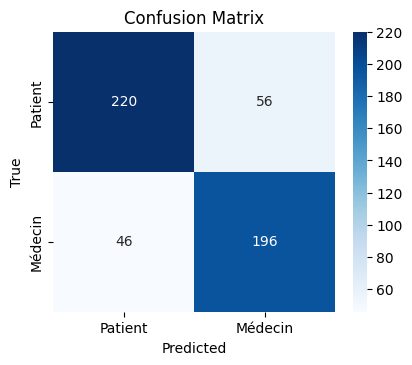

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Charger les embeddings
X_train_drbert = np.load('X_train_drbert_embeddings.npy')
X_test_drbert = np.load('X_test_drbert_embeddings.npy')

# 1. Normalize embeddings
print("Normalizing data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_drbert)
X_test_scaled = scaler.transform(X_test_drbert)

# 2. Prepare targets and encode them
print("Encoding labels...")
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['role_binaire'])
y_test = label_encoder.transform(test_df['role_binaire'])

# 3. Define and train model
print("Training MLPClassifier...")
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='adaptive',
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
    verbose=True
)

mlp.fit(X_train_scaled, y_train)

# 4. Predictions and probabilities
y_pred = mlp.predict(X_test_scaled)
y_proba = mlp.predict_proba(X_test_scaled)

# 5. Performance metrics
print("\n=== Model Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Patient', 'Médecin']))

# 6. Confusion Matrix Visualization
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Patient', 'Médecin'],
            yticklabels=['Patient', 'Médecin'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')


# 7. Precision, Recall, F1 scores for each class
print("\n=== Detailed Performance Metrics ===")
print("Patient:")
print(f"Precision: {cm[0,0]/(cm[0,0]+cm[1,0]):.2%}")
print(f"Recall: {cm[0,0]/(cm[0,0]+cm[0,1]):.2%}")
print(f"F1-score: {2*cm[0,0]/(2*cm[0,0]+cm[0,1]+cm[1,0]):.2%}")

print("\nMédecin:")
print(f"Precision: {cm[1,1]/(cm[1,1]+cm[0,1]):.2%}")
print(f"Recall: {cm[1,1]/(cm[1,1]+cm[1,0]):.2%}")
print(f"F1-score: {2*cm[1,1]/(2*cm[1,1]+cm[1,0]+cm[0,1]):.2%}")


# 10. Analysis of errors with confidence levels
errors = (y_pred != y_test)
error_probs = np.max(y_proba[errors], axis=1)
print("\n=== Error Analysis ===")
print(f"Number of errors: {np.sum(errors)}")
print(f"Average confidence in errors: {error_probs.mean():.2%}")
print(f"Max confidence in errors: {error_probs.max():.2%}")
print(f"Min confidence in errors: {error_probs.min():.2%}")




## 1. Chargement et normalisation des embeddings

1. **Chargement des données**

   ```python
   X_train_drbert = np.load('X_train_drbert_embeddings.npy')
   X_test_drbert  = np.load('X_test_drbert_embeddings.npy')
   ```

   Les fichiers `.npy` contiennent respectivement les vecteurs d’embeddings d’entraînement et de test extraits par un modèle de type « DrBERT ».

2. **Normalisation**

   ```python
   scaler = StandardScaler()
   X_train_scaled = scaler.fit_transform(X_train_drbert)
   X_test_scaled  = scaler.transform(X_test_drbert)
   ```

   On centre et met à l’échelle chaque dimension pour que les données aient moyenne 0 et écart‑type 1. Cela facilite la convergence du réseau de neurones.

---

## 2. Préparation des étiquettes (labels)

1. **Encodage des labels**

   ```python
   label_encoder = LabelEncoder()
   y_train = label_encoder.fit_transform(train_df['role_binaire'])
   y_test  = label_encoder.transform(test_df['role_binaire'])
   ```

   Les rôles « Patient » et « Médecin » sont convertis en 0 et 1. `fit_transform` sur l’ensemble d’entraînement apprend la correspondance, puis `transform` applique cette même correspondance aux labels de test.

---

## 3. Définition et entraînement du MLPClassifier

```python
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='adaptive',
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
    verbose=True
)
mlp.fit(X_train_scaled, y_train)
```

* **Architecture** : trois couches cachées de tailles respectives 256, 128, 64 neurones.
* **Fonction d’activation** : ReLU.
* **Optimisation** : algorithme Adam, avec régularisation L2 (alpha=0.001).
* **Learning rate adaptatif** : le pas d’apprentissage diminue si la performance stagne.
* **Arrêt précoce** : si la perte ne s’améliore pas sur 10 % de l’échantillon de validation.
* **Max\_iter** : 300 itérations (ou moins si early stopping).
* **Verbose** : affichage de la progression d’entraînement.

---

## 4. Prédictions et probabilités

```python
y_pred  = mlp.predict(X_test_scaled)
y_proba = mlp.predict_proba(X_test_scaled)
```

* `y_pred` : classes prédites (0 ou 1).
* `y_proba` : probabilités associées à chaque classe pour chaque exemple.

---

## 5. Mesures de performance

1. **Accuracy globale**

   ```python
   accuracy_score(y_test, y_pred)  # 80.00%
   ```

2. **Rapport de classification**
   Affiche précision, rappel et F1-score pour chaque classe.

3. **Matrice de confusion**
   Visualisée via seaborn :

   ```
   [[TP_patient, FN_patient],
    [FP_médecin, TP_médecin]]
   ```

---

## 6. Calcul manuel des métriques

Pour chaque classe, on calcule :

* **Precision** = TP / (TP + FP)
* **Recall**    = TP / (TP + FN)
* **F1-score**  = 2·TP / (2·TP + FP + FN)

Les valeurs correspondent à celles du rapport automatique.

---

## 7. Analyse des erreurs

```python
errors     = (y_pred != y_test)
error_probs = np.max(y_proba[errors], axis=1)
```

* **Nombre d’erreurs** : 102 sur 518 (≈ 19.7 %).
* **Confiance moyenne sur erreurs** : 70.25 %.
* **Confiance maximale sur erreurs** : 98.40 % (exemples où le modèle était très sûr malgré une prédiction incorrecte).
* **Confiance minimale sur erreurs** : 50.65 % (limite, puisque deux classes).

---

# Analyse des résultats


| Classe  | Précision | Rappel | F1‑score |
| ------- | --------- | ------ | -------- |
| Patient | 82.7 %    | 79.7 % | 81.2 %   |
| Médecin | 77.8 %    | 81.0 % | 79.4 %   |

---

### Interprétation des métriques

1. **Précision**

   * **Patient (82.7 %)** : parmi les uttérances prédites « Patient », 82.7 % sont correctes.
   * **Médecin (77.8 %)** : parmi les uttérances prédites « Médecin », 77.8 % sont exactes.
   * → Le modèle est globalement plus fiable lorsqu’il prédit « Patient » que « Médecin ».

2. **Rappel**

   * **Patient (79.7 %)** : il identifie 79.7 % des vrais Patients.
   * **Médecin (81.0 %)** : il récupère 81.0 % des vrais Médecins.
   * → Le modèle est légèrement meilleur pour ne pas rater les Médecins que pour repérer tous les Patients.

3. **F1‑score**

   * **Patient (81.2 %)** : équilibre solide, montrant que la perte de rappel (20.3 %) et la non‑perfection de précision s’équilibrent autour de 81 %.
   * **Médecin (79.4 %)** : F1 un peu plus faible, dû à une précision plus basse (77.8 %) malgré un rappel comparable.
   * → La classe « Patient » présente un meilleur compromis précision/rappel que la classe « Médecin ».

---




#### AVEC GRID CV ####

Normalisation des données...
Encodage des étiquettes...
Lancement de GridSearchCV...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[CV] END activation=relu, alpha=0.0001, batch_size=32, early_stopping=True, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, max_iter=500, validation_fraction=0.15; total time=   1.1s
[CV] END activation=relu, alpha=0.0001, batch_size=32, early_stopping=True, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, max_iter=500, validation_fraction=0.15; total time=   1.0s
[CV] END activation=relu, alpha=0.0001, batch_size=32, early_stopping=True, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, max_iter=500, validation_fraction=0.15; total time=   1.4s
[CV] END activation=relu, alpha=0.0001, batch_size=32, early_stopping=True, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, max_iter=500, validation_fraction=0.15; total time=   1.6s
[CV] END activation=relu, alpha=0.0001, batch_size=32, early_stopping=True, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, max_

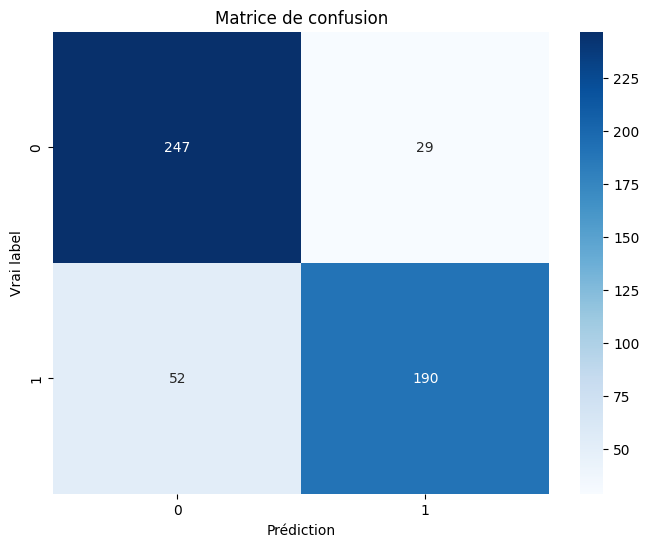


Analyse des erreurs les plus confiantes :


,utterance,utterance_length,y_true,y_pred,proba_pred
2354,donc là il faut que je prenne la voiture et qu...,128,patient,medecin,0.995684
1550,encore vomi du sang et y'en a qui sort par la ...,66,patient,medecin,0.991368
1637,voilà n'hésitez pas à rappeler dans une demi h...,60,medecin,patient,0.977899
1072,"quand même , heu ma mère je la connais . je vo...",177,patient,medecin,0.975065
2233,vous pensez que c'est grave ?,29,patient,medecin,0.967342
2799,c'est possible que quelqu'un faut que j'aille ...,147,patient,medecin,0.966650
1794,merc- oui vous voulez que je vous repasse ma c...,64,patient,medecin,0.966484
2583,ça fait quelques jours qu'il man- qu'il mange ...,127,patient,medecin,0.965067
173,vous pensez pas ? la paralysie du bras ?,40,patient,medecin,0.963387
32,d'accord,8,patient,medecin,0.955197


In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

# 1. Normaliser les embeddings
print("Normalisation des données...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_drbert)
X_test_scaled = scaler.transform(X_test_drbert)

# 2. Encodage des étiquettes
print("Encodage des étiquettes...")
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['role_binaire'])
y_test = label_encoder.transform(test_df['role_binaire'])

# 3. Définir la grille d'hyperparamètres optimisée
param_grid = {
    'hidden_layer_sizes': [
        (64,),          # Architecture simple pour petites utterances
        (128, 64),      # Architecture moyenne
        (256, 128, 64)  # Architecture plus profonde
    ],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],  # Plus de choix de régularisation
    'learning_rate': ['adaptive'],
    'batch_size': [32, 64, 128],     # Différentes tailles de batch
    'early_stopping': [True],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [500],               # Plus d'itérations
    'validation_fraction': [0.15]    # Plus de données pour la validation
}

# 4. Initialiser le modèle de base avec des paramètres adaptés
mlp_base = MLPClassifier(
    solver='adam',
    random_state=42,
    n_iter_no_change=20,            # Plus patient avant early stopping
    tol=1e-4                        # Critère de convergence moins strict
)

# 5. Grid Search avec validation croisée (5-fold au lieu de 3)
print("Lancement de GridSearchCV...")
grid_search = GridSearchCV(
    estimator=mlp_base,
    param_grid=param_grid,
    cv=5,                          # Plus de folds pour plus de robustesse
    n_jobs=-1,
    verbose=2,
    scoring='f1_weighted'          # Métrique plus adaptée pour données déséquilibrées
)

grid_search.fit(X_train_scaled, y_train)

# 6. Meilleurs paramètres et entraînement final
print("\nMeilleurs paramètres trouvés :")
print(grid_search.best_params_)

# 7. Évaluation du meilleur modèle sur les données de test
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test_scaled)
y_proba = best_mlp.predict_proba(X_test_scaled)

print("\nÉvaluation sur l'ensemble de test :")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.2%}")
print("\nClassification Report :")
print(classification_report(y_test, y_pred))

# 8. Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.show()

# 9. Analyse des erreurs
errors_df = test_df.copy()
errors_df['y_true'] = label_encoder.inverse_transform(y_test)
errors_df['y_pred'] = label_encoder.inverse_transform(y_pred)
errors_df['proba_pred'] = y_proba.max(axis=1)
errors_df['is_error'] = errors_df['y_true'] != errors_df['y_pred']

# Ajouter longueur des utterances
errors_df['utterance_length'] = errors_df['utterance'].str.len()

# Afficher les erreurs les plus confiantes
errors_sample = errors_df[errors_df['is_error']].sort_values(
    by=['proba_pred', 'utterance_length'], 
    ascending=[False, True]
).head(20)[['utterance', 'utterance_length', 'y_true', 'y_pred', 'proba_pred']]

print("\nAnalyse des erreurs les plus confiantes :")
display(errors_sample)

## Comparaison des performances des modèles

### Random Forest
- Sans GridCV : ~80% d'accuracy
- Avec GridCV : ~81% d'accuracy
    - Légère amélioration grâce à l'optimisation des hyperparamètres

### MLP (Multi-Layer Perceptron) 
- Sans GridCV : ~80% d'accuracy 
- Avec GridCV : ~84.36% d'accuracy
    - Amélioration significative de 4-5% sur toutes les métriques
    - Architecture optimisée avec early stopping

### Points communs
- Meilleur rappel sur la classe "patient"
- Meilleure précision sur la classe "médecin" 

### Conclusion
- Le MLP surpasse le Random Forest après optimisation
- Les réseaux de neurones semblent plus adaptés pour exploiter les embeddings médicaux
- La recherche d'hyperparamètres (GridCV) améliore les performances, particulièrement pour le MLP

## Partie D
Création d'une visualisation libre du jeu de données:
  * par exemple: clustering/PCA des embeddings d'uttérances
  * autre exemple: visualisation de la trajectoire du score du modèle de la partie C au fil de la conversation

AVEC GRIDCV


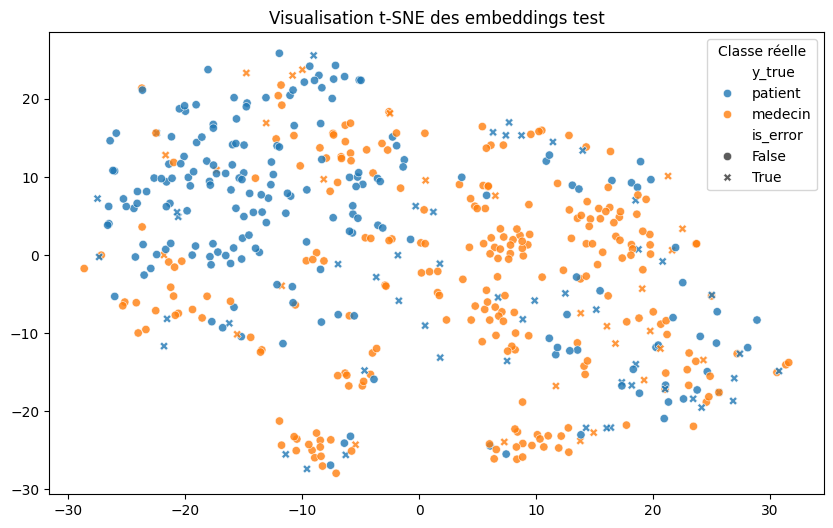

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_proj = tsne.fit_transform(X_test_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_proj[:,0], y=X_proj[:,1], hue=errors_df['y_true'], style=errors_df['is_error'], alpha=0.8)
plt.title("Visualisation t-SNE des embeddings test")
plt.legend(title="Classe réelle")
plt.show()


🧠 Décomposition de cette t-SNE :
Axe x et y : Ce sont des dimensions fictives créées par l’algorithme t-SNE. Ils ne représentent pas des variables directement interprétables mais permettent de voir comment les points se regroupent.

Couleurs :

🟠 patient

🔵 medecin

Ces couleurs représentent la classe réelle y_true.

Formes :

Point plein (•) : is_error = False → prédiction correcte

Croix (×) : is_error = True → erreur de prédiction

Légende :

La légende « Classe réelle » indique les couleurs.

La légende « is_error » indique si le modèle a fait une erreur (True/False).

🔍 Analyse de la visualisation :
Séparation des classes (patients vs médecins) :

Il y a un certain chevauchement entre les deux classes, mais aussi des zones de concentration nette de l’un ou l’autre groupe.

Cela suggère que les embeddings ont capturé une certaine structure permettant une classification partielle.

Erreurs de classification :

Les croix (×) sont réparties sur toute la carte, mais elles apparaissent surtout dans les zones de transition entre les deux groupes (mélange d’orange et de bleu).

Cela indique que le modèle se trompe surtout dans les cas ambigus, quand un embedding est proche de l’autre classe.

Qualité du modèle :

Il y a beaucoup plus de points pleins (prédictions correctes) que de croix.

Cela suggère que le modèle a une bonne performance globale, même s’il y a des zones confuses.

Regroupements spatiaux :

Le t-SNE forme des "îlots" , indiquant que certains profils (patients ou médecins) ont des caractéristiques très similaires entre eux (bonne cohérence des embeddings).

✅ En résumé :
La t-SNE montre que les embeddings capturent bien la distinction patient / médecin, avec quelques zones ambiguës.


Cette visualisation est utile pour diagnostiquer où le modèle se trompe.